Problem Statement
Demand Forecast is one of the key tasks in Supply Chain and Retail Domain in general. It is key in effective operation and optimization of retail supply chain. Effectively solving this problem requires knowledge about a wide range of tricks in Data Sciences and good understanding of ensemble techniques. 
You are required to predict sales for each Store-Day level for one month. All the features will be provided and actual sales that happened during that month will also be provided for model evaluation. 

In [3]:
# Importing necessary libraries 
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
import pandas as pd
import numpy as np
import re
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RNN, Bidirectional, SimpleRNNCell
import keras_tuner as kt

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Exploratory Data Analysis (EDA) and Linear Regression:
We convert the date to date time pandas object, clean the data frame of null, missing and duplicate values. 
Fix the stateholiday column with multiple datatypes and one hot encode it.
Next we check for distribution and correlation with respect to sales. And choose the relevant features.
And finally remove outliers from sales.

<>:18: SyntaxWarning: invalid escape sequence '\A'
<>:18: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_435104/403526016.py:18: SyntaxWarning: invalid escape sequence '\A'
  print('Columns with N\A values:')
/tmp/ipykernel_435104/403526016.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  rawIdata = pd.read_csv('train_data.csv') # training dataset


Training dataframe:
         Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
0           1          2  2015-06-30   5735        568     1      1   
1           2          2  2015-06-30   9863        877     1      1   
2           3          2  2015-06-30  13261       1072     1      1   
3           4          2  2015-06-30  13106       1488     1      1   
4           5          2  2015-06-30   6635        645     1      1   
...       ...        ...         ...    ...        ...   ...    ...   
982639   1111          2  2013-01-01      0          0     0      0   
982640   1112          2  2013-01-01      0          0     0      0   
982641   1113          2  2013-01-01      0          0     0      0   
982642   1114          2  2013-01-01      0          0     0      0   
982643   1115          2  2013-01-01      0          0     0      0   

       StateHoliday  SchoolHoliday  
0                 0              0  
1                 0              0  
2              

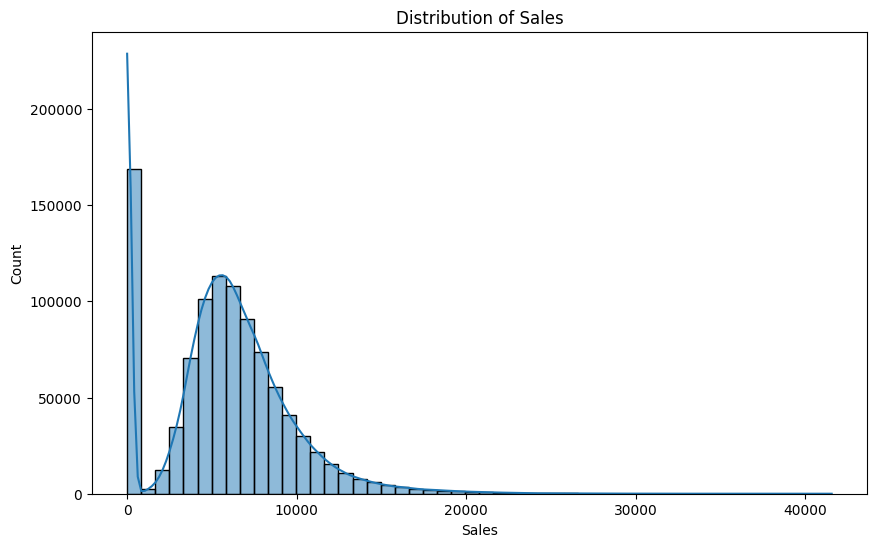

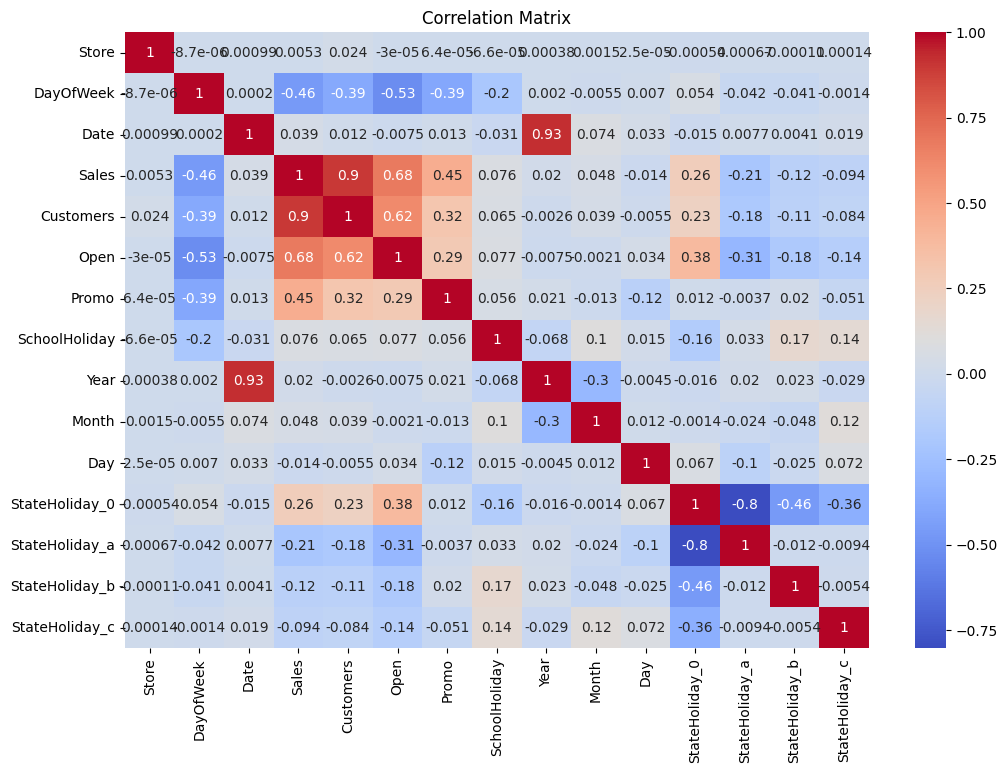

        Store  Sales  Customers  Open  Promo  SchoolHoliday  Year  Month  \
935493    794   2780        498     1      0              1  2013      2   
557474    760      0          0     0      0              0  2014      1   
634238    589   3140        340     1      0              0  2013     11   
975770    931   4318        426     1      1              0  2013      1   
962327    868  10343        702     1      0              0  2013      1   
...       ...    ...        ...   ...    ...            ...   ...    ...   
301583    791   8193        888     1      1              0  2014      9   
813419    255   6389        745     1      0              0  2013      6   
363272    767   3827        373     1      0              0  2014      7   
302281    503   9394        544     1      1              0  2014      9   
869319    405   5333        552     1      1              0  2013      4   

        StateHoliday_0  
935493             1.0  
557474             1.0  
634238      

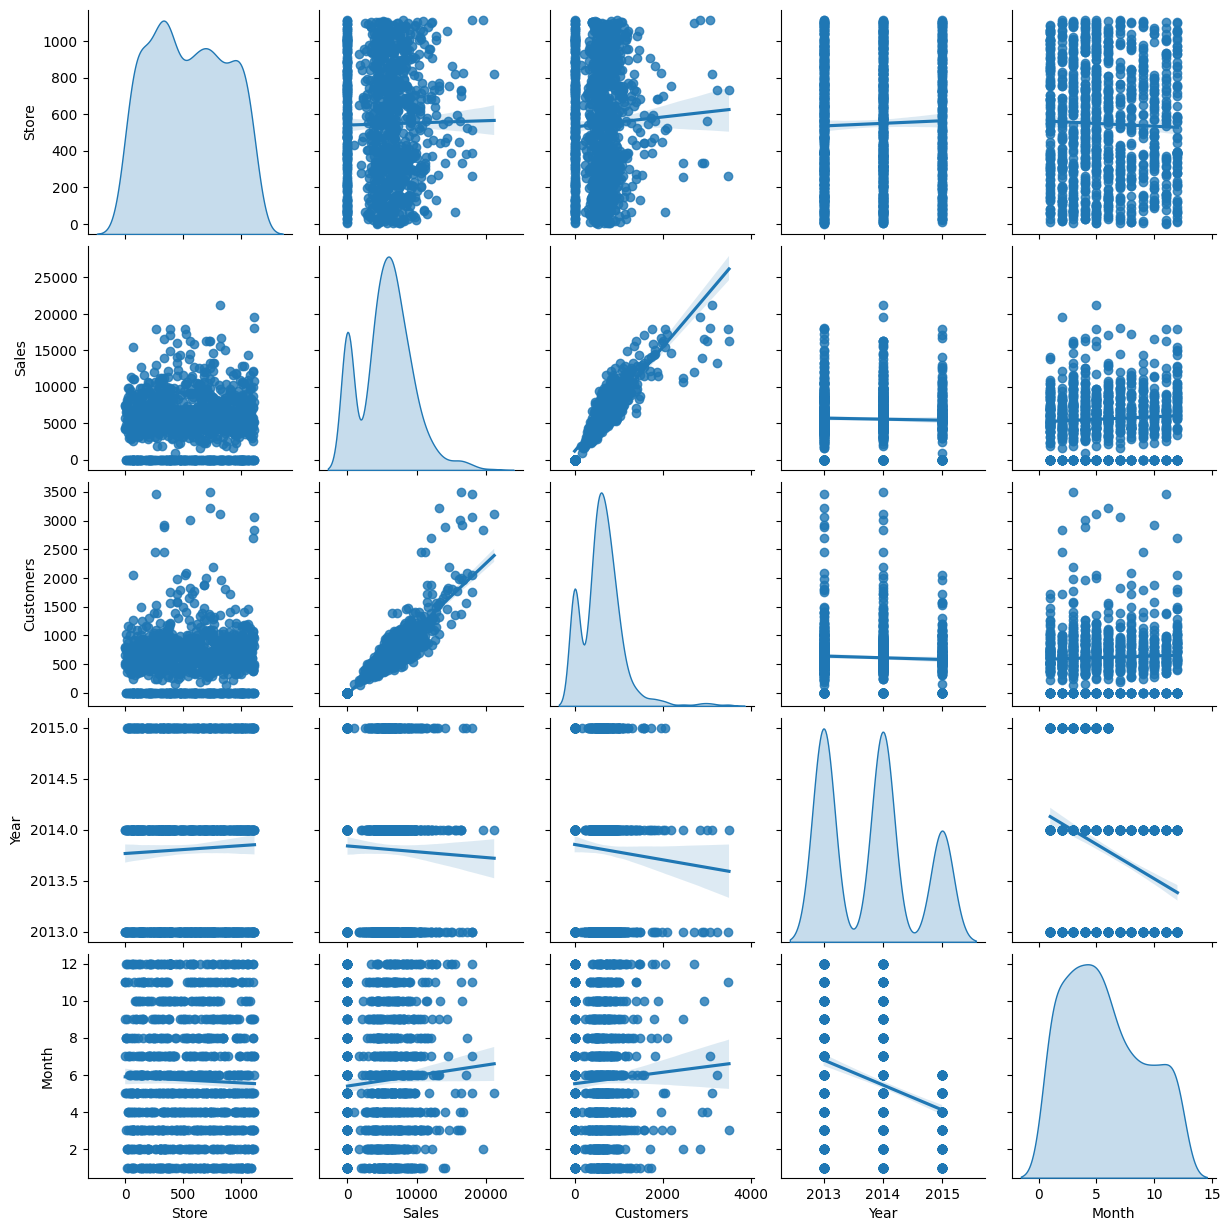

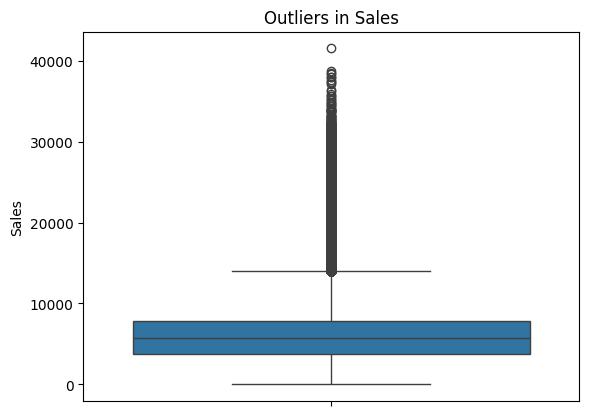

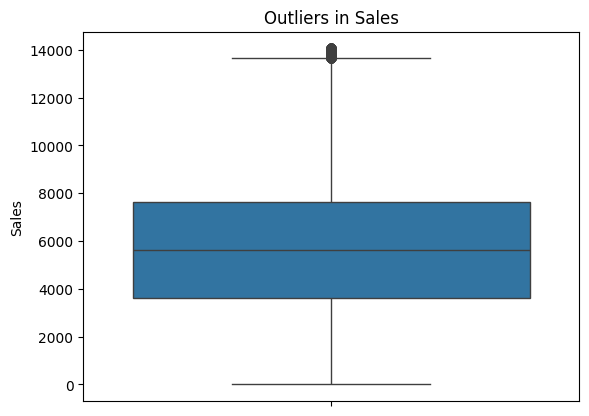

In [4]:
# importing the data files using pandas.read_csv reads the csv file 
rawIdata = pd.read_csv('train_data.csv') # training dataset
print('Training dataframe:\n',rawIdata)

# Checking data types
print('Datatypes for each column:\n',rawIdata.dtypes)

# Convert 'Date' column to datetime
rawIdata['Date'] = pd.to_datetime(rawIdata['Date'])
# Extract useful date features
rawIdata['Year'] = rawIdata['Date'].dt.year
rawIdata['Month'] = rawIdata['Date'].dt.month
rawIdata['Day'] = rawIdata['Date'].dt.day

# Check for missing, null and duplicate values 
print('Columns with Null values:')
print(rawIdata.isnull().sum())
print('Columns with N\A values:')
print(rawIdata.isna().sum())
print('Columns with duplicated values:')
print(rawIdata.duplicated().sum())

# Clean the data by removing or correcting any errors
rawIdata.drop_duplicates(inplace=True)
rawIdata.dropna(inplace=True)

# Analyzing Stateholiday column 
unique_values = rawIdata['StateHoliday'].unique()
print('Unique values of StateHoliday\n',unique_values)
# Counting the number of string and integer values 
print("Number of string values:", rawIdata['StateHoliday'].apply(type).eq(str).sum())
print("Total number of values:", rawIdata['StateHoliday'].apply(type).eq(int).sum())
# Since we have mostly string values of 0, a , b and c and few integer 0 value 
# we wil convert the integer 0 value to a sting 0 
rawIdata['StateHoliday'] = [str(value) for value in rawIdata['StateHoliday']]
print(rawIdata['StateHoliday'].unique())

# One-Hot Encoding of StateHoliday
encoder = OneHotEncoder(sparse_output=False)
OHE = encoder.fit_transform(rawIdata[['StateHoliday']])
encoded_features = pd.DataFrame(OHE, columns=encoder.get_feature_names_out(['StateHoliday']))
rawIdata.drop(labels=['StateHoliday'], axis=1, inplace=True)
rawIdata = pd.concat([rawIdata, encoded_features], axis=1)
print(rawIdata)

# Exploratory Data Analysis (EDA)
# Plot the distribution of Sales
plt.figure(figsize=(10,6))
sns.histplot(rawIdata['Sales'], bins=50, kde=True)
plt.title("Distribution of Sales")
plt.show()

# Correlation heatmap to visualize the correlation between features
plt.figure(figsize=(12,8))
sns.heatmap(rawIdata.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Analysing the correlation matrix with respect to sales, we can determine which features to be used as inputs to the model
# Since dayofweek, day, StateHoliday_a, StateHoliday_b and StateHoliday_c have negative correlation we drop this features
# also since we cant use datetime object we drop date column
col = ['Store','Sales','Customers','Open','Promo', 'SchoolHoliday', 'Year','Month', 'StateHoliday_0'] # relevant features

# Correlation of integer features with respect to weekly sales
Samples=rawIdata[col].sample(1000) # making an instace of original dataset with less samples (rows)
print(Samples)
sns.pairplot(Samples[['Store','Sales','Customers','Year','Month']], diag_kind='kde', kind='reg')
plt.show()

# checking outliers for sales
plt.title(f'Outliers in Sales')
sns.boxplot(rawIdata['Sales'])
plt.show()

# Step 1: Remove Outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remove outliers
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply outlier removal on the target column (Sales)
rawIdata = remove_outliers(rawIdata, 'Sales')

# checking outliers for sales
plt.title(f'Outliers in Sales')
sns.boxplot(rawIdata['Sales'])
plt.show()



We apply Linear Regression to predict the forecast and evaluate different accuracy metrics like RMSE (Root Mean Squared Error) and MAE(Mean Absolute Error) and determined that MAE makes more sense, since its a metric that calculates the average magnitude of the absolute errors between the predicted and actual values. Furthermore, we use R2 as metric for accuracy, as it is easy to interpret.
we apply the whole dataset with all stores to train a single model and get good accuracy.

In [6]:
#Splitting Data for Training and Testing
# Define target variable and features
Idata = rawIdata[col] # Droping irrelevant features, keeping only relevant ones that have correlation above 0 with sales
X = Idata.drop(columns=['Sales'])  # Exclude 'Sales'
y = Idata['Sales']
print(X)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['Store'])

from sklearn.preprocessing import StandardScaler
# Standardization (for models that require it, like Linear Regression and Neural Networks)
scaler = StandardScaler()

# Apply standardization to only integer features (ignoring the one-hot encoded categorical feature and other boolean features)
# Only Integer  columns that need standardiztion is Customers and Year
# Standardize only Customer and year column
X_train[['Customers','Year']] = scaler.fit_transform(X_train[['Customers','Year']])
X_test[['Customers','Year']] = scaler.transform(X_test[['Customers','Year']])
print(X_train)

#Linear Regression Model
# Train a single linear regression model for all stores
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict on the test set
y_pred_linear = linear_model.predict(X_test)

# Evaluate Linear Regression Model
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))
mae_linear = mean_absolute_error(y_test, y_pred_linear)

print(f"Linear Regression RMSE: {rmse_linear}")
print(f"Linear Regression MAE: {mae_linear}")

# Convert MAE and RMSE to percentages
mae_linear_percent = (mae_linear / np.mean(y_test)) * 100
rmse_linear_percent = (rmse_linear / np.mean(y_test)) * 100

# Print results for each store
print(f" MAE: {mae_linear_percent:.2f}% | RMSE: {rmse_linear_percent:.2f}%")

# Using a better interpretable accuracy metrics
score = linear_model.score(X_test, y_test)
print(f"\nThe R2 score of the Linear Regression model on the testing data is: {score*100:.2f} % Accuracy")

        Store  Customers  Open  Promo  SchoolHoliday  Year  Month  \
0           1        568     1      1              0  2015      6   
1           2        877     1      1              0  2015      6   
2           3       1072     1      1              1  2015      6   
3           4       1488     1      1              0  2015      6   
4           5        645     1      1              0  2015      6   
...       ...        ...   ...    ...            ...   ...    ...   
982639   1111          0     0      0              1  2013      1   
982640   1112          0     0      0              1  2013      1   
982641   1113          0     0      0              1  2013      1   
982642   1114          0     0      0              1  2013      1   
982643   1115          0     0      0              1  2013      1   

        StateHoliday_0  
0                  1.0  
1                  1.0  
2                  1.0  
3                  1.0  
4                  1.0  
...                ..

Now we train separate LR model for each store and found out that this model performs better than the single model.

In [7]:
# Analyzing Stateholiday column 
unique_stores = rawIdata['Store'].unique()
print('Unique values of Stores\n',unique_stores, '\n and total number of unique stores:', unique_stores.sum())


# Store MAE, R2 and RMSE results for each store
store_mae = {}
store_rmse = {}
store_R2 = {}
# Iterate over each store and train a separate linear regression model
for store in unique_stores:
    # Since store 262 predicts NAN R2 score we dont train on it
    if store == 262:
        break
    # Define target variable and features
    Idata = rawIdata[col] # Droping irrelevant features, keeping only relevant ones that have correlation above 0 with sales
    # Filter data for the specific store
    store_data = Idata[Idata['Store'] == store]
    
    # Split data into features and target
    X_store = store_data.drop(columns=['Sales'])  # We still drop Customers and Date
    y_store = store_data['Sales']
    
    # Split into train and test sets
    X_train_store, X_test_store, y_train_store, y_test_store = train_test_split(X_store, y_store, test_size=0.2, random_state=42)
    
    # Standardize only the numeric features if needed (e.g., for Linear Regression)
    X_train_store[['Customers','Year']] = scaler.fit_transform(X_train_store[['Customers','Year']])
    X_test_store[['Customers','Year']] = scaler.transform(X_test_store[['Customers','Year']])
    #
    # Train the linear regression model for the specific store
    model_store = LinearRegression()
    model_store.fit(X_train_store, y_train_store)
    
    # Predict on the test set for the store
    y_pred_store = model_store.predict(X_test_store)
    
    # Calculate MAE and RMSE for the store
    mae_store = mean_absolute_error(y_test_store, y_pred_store)
    rmse_store = np.sqrt(mean_squared_error(y_test_store, y_pred_store))
    R2_score = model_store.score(X_test_store, y_test_store)
    
    # Convert MAE and RMSE to percentages
    mae_store_percent = (mae_store / np.mean(y_test_store)) * 100
    rmse_store_percent = (rmse_store / np.mean(y_test_store)) * 100
    
    # Store the results
    store_mae[store] = mae_store_percent
    store_rmse[store] = rmse_store_percent
    store_R2[store] = R2_score*100
    
    # Print results for each store
    print(f"Store {store} - MAE: {mae_store_percent:.2f}% | RMSE: {rmse_store_percent:.2f}% | R2_score: {R2_score:.2f}% ")

# Analyze the overall performance by taking the average MAE, R2 and RMSE across all stores
average_mae_per_store = np.mean(list(store_mae.values()))
average_rmse_per_store = np.mean(list(store_rmse.values()))
average_R2_per_store = np.mean(list(store_R2.values()))

print(f"Average MAE across all stores: {average_mae_per_store:.2f}%")
print(f"Average RMSE across all stores: {average_rmse_per_store:.2f}%")

# Using a better interpretable accuracy metrics
print(f"\nThe R2 score of the Linear Regression model on the testing data is: {average_R2_per_store:.2f} % Accuracy")

Unique values of Stores
 [  1   2   3 ... 562 733 262] 
 and total number of unique stores: 622170
Store 1 - MAE: 5.04% | RMSE: 6.70% | R2_score: 0.98% 
Store 2 - MAE: 7.69% | RMSE: 13.33% | R2_score: 0.95% 
Store 3 - MAE: 6.24% | RMSE: 8.02% | R2_score: 0.98% 
Store 4 - MAE: 3.76% | RMSE: 4.89% | R2_score: 0.99% 
Store 5 - MAE: 8.89% | RMSE: 11.76% | R2_score: 0.97% 
Store 6 - MAE: 5.64% | RMSE: 7.35% | R2_score: 0.98% 
Store 8 - MAE: 7.27% | RMSE: 9.96% | R2_score: 0.97% 
Store 9 - MAE: 4.47% | RMSE: 6.46% | R2_score: 0.99% 
Store 10 - MAE: 5.44% | RMSE: 6.85% | R2_score: 0.98% 
Store 11 - MAE: 6.10% | RMSE: 8.16% | R2_score: 0.97% 
Store 12 - MAE: 5.09% | RMSE: 7.07% | R2_score: 0.98% 
Store 13 - MAE: 6.62% | RMSE: 8.57% | R2_score: 0.98% 
Store 14 - MAE: 5.28% | RMSE: 7.07% | R2_score: 0.98% 
Store 15 - MAE: 5.66% | RMSE: 7.56% | R2_score: 0.98% 
Store 16 - MAE: 6.75% | RMSE: 8.56% | R2_score: 0.97% 
Store 17 - MAE: 6.98% | RMSE: 9.59% | R2_score: 0.98% 
Store 18 - MAE: 6.66% | RMS

Now we see if we can improve performance by Ensemble both the single and separate model, however this performs worse than those before.

In [8]:

#Splitting Data for Training and Testing
# Define target variable and features
Idata = rawIdata[col] # Droping irrelevant features, keeping only relevant ones that have correlation above 0 with sales
X = Idata.drop(columns=['Sales'])  # Exclude 'Sales'
y = Idata['Sales']
print(X)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['Store'])


# Standardization (for models that require it, like Linear Regression and Neural Networks)
scaler = StandardScaler()

# Apply standardization to only integer features (ignoring the one-hot encoded categorical feature and other boolean features)
# Only Integer  columns that need standardiztion is Customers and Year
# Standardize only Customer and year column
X_train[['Customers','Year']] = scaler.fit_transform(X_train[['Customers','Year']])
X_test[['Customers','Year']] = scaler.transform(X_test[['Customers','Year']])

#Linear Regression Model
# Train a single linear regression model for all stores
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Analysing Stateholiday column 
unique_stores = rawIdata['Store'].unique()
print('Unique values of Stores\n',unique_stores, '\n and total number of unique stores:', unique_stores.sum())

# Store MAE, R2 and RMSE results for each store
store_mae = {}
store_rmse = {}
store_R2 = {}
# Iterate over each store and train a separate linear regression model
for store in unique_stores:
    if store == 262:
        break
    # Filter data for the specific store
    store_data = Idata[Idata['Store'] == store]
    
    # Split data into features and target
    X_store = store_data.drop(columns=['Sales'])  # We still drop Customers and Date
    y_store = store_data['Sales']
    
    # Split into train and test sets
    X_train_store, X_test_store, y_train_store, y_test_store = train_test_split(X_store, y_store, test_size=0.2, random_state=42)
    
    # Standardize only the numeric features if needed (e.g., for Linear Regression)
    X_train_store[['Customers','Year']] = scaler.fit_transform(X_train_store[['Customers','Year']])
    X_test_store[['Customers','Year']] = scaler.transform(X_test_store[['Customers','Year']])
    #
    # Train the linear regression model for the specific store
    model_store = LinearRegression()
    model_store.fit(X_train_store, y_train_store)
    
    # Predict on the test set for the store
    y_pred_store = model_store.predict(X_test_store)
    y_pred_linear = linear_model.predict(X_test_store)
    # Average the predictions from the general model and store-specific model ensembled
    y_pred_ensemble = (y_pred_store + y_pred_linear) / 2
    
    # Calculate MAE and RMSE for the store
    mae_store = mean_absolute_error(y_test_store, y_pred_ensemble)
    rmse_store = np.sqrt(mean_squared_error(y_test_store, y_pred_ensemble))
    
    # Convert MAE and RMSE to percentages
    mae_store_percent = (mae_store / np.mean(y_test_store)) * 100
    rmse_store_percent = (rmse_store / np.mean(y_test_store)) * 100

    # For R2 score ensembled
    R2_score = linear_model.score(X_test_store, y_test_store)
    R2_score_store = model_store.score(X_test_store, y_test_store)
    R2_score_ensemble = (R2_score + R2_score_store) / 2
    
    # Store the results
    store_mae[store] = mae_store_percent
    store_rmse[store] = rmse_store_percent
    store_R2[store] = R2_score_ensemble
    
    # Print results for each store
    print(f"Store {store} - MAE: {mae_store_percent:.2f}% | RMSE: {rmse_store_percent:.2f}% | R2_score: {R2_score_ensemble*100:.2f}% ")

# Analyze the overall performance by taking the average MAE, R2 and RMSE across all stores
average_mae_per_store = np.mean(list(store_mae.values()))
average_rmse_per_store = np.mean(list(store_rmse.values()))
average_R2_per_store = np.mean(list(store_R2.values()))

print(f"Average MAE across all stores: {average_mae_per_store:.2f}%")
print(f"Average RMSE across all stores: {average_rmse_per_store:.2f}%")

# Using a better interpretable accuracy metrics
print(f"\nThe R2 score of the Linear Regression model on the testing data is: {average_R2_per_store*100:.2f} % Accuracy")

        Store  Customers  Open  Promo  SchoolHoliday  Year  Month  \
0           1        568     1      1              0  2015      6   
1           2        877     1      1              0  2015      6   
2           3       1072     1      1              1  2015      6   
3           4       1488     1      1              0  2015      6   
4           5        645     1      1              0  2015      6   
...       ...        ...   ...    ...            ...   ...    ...   
982639   1111          0     0      0              1  2013      1   
982640   1112          0     0      0              1  2013      1   
982641   1113          0     0      0              1  2013      1   
982642   1114          0     0      0              1  2013      1   
982643   1115          0     0      0              1  2013      1   

        StateHoliday_0  
0                  1.0  
1                  1.0  
2                  1.0  
3                  1.0  
4                  1.0  
...                ..

We next use Regularized Regression lik Ridge and lasso, this models also perform similar to single linear regression model.

In [9]:
#Splitting Data for Training and Testing
# Define target variable and features
Idata = rawIdata[col] # Droping irrelevant features, keeping only relevant ones that have correlation above 0 with sales
X = Idata.drop(columns=['Sales'])  # Exclude 'Sales'
y = Idata['Sales']
print(X)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['Store'])
#Regularized Regression (Ridge and Lasso)
# Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

# Evaluate Ridge Regression Model
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)

print(f"Ridge Regression RMSE: {rmse_ridge}")
print(f"Ridge Regression MAE: {mae_ridge}")

# Convert MAE and RMSE to percentages
mae_percent = (mae_ridge / np.mean(y_test)) * 100
rmse_percent = (rmse_ridge / np.mean(y_test)) * 100

# Print results for each store
print(f"Ridge Regression MAE: {mae_percent:.2f}% | RMSE: {rmse_percent:.2f}%")

# Using a better interpretable accuracy metrics
Ridge_score = ridge_model.score(X_test, y_test)
print(f"\nThe R2 score of the Ridge Regression model on the testing data is: {Ridge_score*100:.2f} % Accuracy")

# Lasso Regression
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)

# Evaluate Lasso Regression Model
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)

print(f"Lasso Regression RMSE: {rmse_lasso}")
print(f"Lasso Regression MAE: {mae_lasso}")

# Convert MAE and RMSE to percentages
mae_percent = (mae_lasso / np.mean(y_test)) * 100
rmse_percent = (rmse_lasso / np.mean(y_test)) * 100

# Print results for each store
print(f"Lasso Regression MAE: {mae_percent:.2f}% | RMSE: {rmse_percent:.2f}%")

# Using a better interpretable accuracy metrics
Lasso_score = lasso_model.score(X_test, y_test)
print(f"\nThe R2 score of the Lasso Regression model on the testing data is: {Lasso_score*100:.2f} % Accuracy")

        Store  Customers  Open  Promo  SchoolHoliday  Year  Month  \
0           1        568     1      1              0  2015      6   
1           2        877     1      1              0  2015      6   
2           3       1072     1      1              1  2015      6   
3           4       1488     1      1              0  2015      6   
4           5        645     1      1              0  2015      6   
...       ...        ...   ...    ...            ...   ...    ...   
982639   1111          0     0      0              1  2013      1   
982640   1112          0     0      0              1  2013      1   
982641   1113          0     0      0              1  2013      1   
982642   1114          0     0      0              1  2013      1   
982643   1115          0     0      0              1  2013      1   

        StateHoliday_0  
0                  1.0  
1                  1.0  
2                  1.0  
3                  1.0  
4                  1.0  
...                ..

Next we use Non-Linear Regressors like Random Forest on the whole dataset with all stores to train a single model. This finally performs similar to the separate models trained on normal LR.

In [10]:
# Random Forest Model (Tree-Based Regressor)
# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=10, random_state=42, verbose=2)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate Random Forest Model
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f"Random Forest RMSE: {rmse_rf}")
print(f"Random Forest MAE: {mae_rf}")

# Convert MAE and RMSE to percentages
mae_percent = (mae_rf / np.mean(y_test)) * 100
rmse_percent = (rmse_rf / np.mean(y_test)) * 100

# Print results for each store
print(f"Lasso Regression MAE: {mae_percent:.2f}% | RMSE: {rmse_percent:.2f}%")

# Using a better interpretable accuracy metrics
RF_score = rf_model.score(X_test, y_test)
print(f"\nThe R2 score of the Lasso Regression model on the testing data is: {RF_score*100:.2f} % Accuracy")

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
Random Forest RMSE: 609.0795683135844
Random Forest MAE: 374.6872476133743
Lasso Regression MAE: 6.86% | RMSE: 11.15%

The R2 score of the Lasso Regression model on the testing data is: 96.75 % Accuracy


Applying Dimensional Reduction techniques like, PCA on the input training set. However, the linear model trained on this performs worse than a normal linear regression model.

In [11]:
# Apply PCA to reduce dimensions
pca = PCA(n_components=0.95)  # Preserve 95% variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train and evaluate a model using the reduced features
linear_model_pca = LinearRegression()
linear_model_pca.fit(X_train_pca, y_train)
y_pred_pca = linear_model_pca.predict(X_test_pca)

# Evaluate the model on PCA-transformed data
rmse_pca = np.sqrt(mean_squared_error(y_test, y_pred_pca))
mae_pca = mean_absolute_error(y_test, y_pred_pca)

print(f"PCA Linear Regression RMSE: {rmse_pca}")
print(f"PCA Linear Regression MAE: {mae_pca}")

# Convert MAE and RMSE to percentages
mae_percent = (mae_pca / np.mean(y_test)) * 100
rmse_percent = (rmse_pca / np.mean(y_test)) * 100

# Print results for each store
print(f" MAE: {mae_percent:.2f}% | RMSE: {rmse_percent:.2f}%")

# Using a better interpretable accuracy metrics
score = linear_model_pca.score(X_test_pca, y_test)
print(f"\nThe R2 score of the Linear Regression model on the testing data is: {score*100:.2f} % Accuracy")

PCA Linear Regression RMSE: 1554.601894321551
PCA Linear Regression MAE: 1132.444061860743
 MAE: 20.73% | RMSE: 28.46%

The R2 score of the Linear Regression model on the testing data is: 78.82 % Accuracy


When store is closed, sales = 0. we apply this to datframe to clean it further and see that it doesnt improve our linear model any further.

In [12]:
# Clean the data: if Open = 0, ensure Sales = 0
data_cleaned_with_rule = Idata
x= data_cleaned_with_rule.loc[data_cleaned_with_rule['Open'] == 0, 'Sales'] = 0
print(x)

# Check if we had any cases where this rule was violated before cleaning
violations_before_cleaning = Idata[(Idata['Open'] == 0) & (Idata['Sales'] != 0)]
print(f"Number of violations before cleaning: {len(violations_before_cleaning)}")

# Retrain the normal linear regression model after cleaning
X_cleaned = data_cleaned_with_rule.drop(columns=['Sales'])
y_cleaned = data_cleaned_with_rule['Sales']

X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)

# Standardize the numeric features
X_train_cleaned[['Customers','Year']] = scaler.fit_transform(X_train_cleaned[['Customers','Year']])
X_test_cleaned[['Customers','Year']] = scaler.transform(X_test_cleaned[['Customers','Year']])

# Train the cleaned model
cleaned_model = LinearRegression()
cleaned_model.fit(X_train_cleaned, y_train_cleaned)

# Get predictions and evaluate the performance
y_pred_cleaned = cleaned_model.predict(X_test_cleaned)

# Calculate MAE and RMSE for the cleaned model
mae_cleaned = mean_absolute_error(y_test_cleaned, y_pred_cleaned)
rmse_cleaned = np.sqrt(mean_squared_error(y_test_cleaned, y_pred_cleaned))

# Convert MAE and RMSE to percentages
mae_cleaned_percent = (mae_cleaned / np.mean(y_test_cleaned)) * 100
rmse_cleaned_percent = (rmse_cleaned / np.mean(y_test_cleaned)) * 100

print(f"MAE after cleaning: {mae_cleaned_percent:.2f}%")
print(f"RMSE after cleaning: {rmse_cleaned_percent:.2f}%")

# Compare to original model's performance
print(f"MAE Original: {mae_linear_percent:.2f}% | MAE Cleaned: {mae_cleaned_percent:.2f}%")
print(f"RMSE Original: {rmse_linear_percent:.2f}% | RMSE Cleaned: {rmse_cleaned_percent:.2f}%")

# Using a better interpretable accuracy metrics
score = linear_model.score(X_test_cleaned, y_test_cleaned)
print(f"\nThe R2 score of the Linear Regression model on the testing data is: {score*100:.2f} % Accuracy")


0
Number of violations before cleaning: 0
MAE after cleaning: 16.82%
RMSE after cleaning: 23.89%
MAE Original: 16.82% | MAE Cleaned: 16.82%
RMSE Original: 23.93% | RMSE Cleaned: 23.89%

The R2 score of the Linear Regression model on the testing data is: 85.10 % Accuracy


Training a Time-series model keras RNN on the data taking time as the only feature with window size for past 30days to predict the sales. We apply the same to LSTM model and get similar results.

In [13]:
Idata = rawIdata[['Store','Date','Sales','Customers','Open','Promo', 'SchoolHoliday', 'StateHoliday_0']]
# Sort data by Date for time-series analysis
date_data = Idata.sort_values('Date')
print(date_data)

# Scale the Sales data
scaler = MinMaxScaler(feature_range=(0, 1))
date_data['Sales_scaled'] = scaler.fit_transform(date_data['Sales'].values.reshape(-1, 1))
print(date_data)

# Create time-series data
def create_recurrent_data(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])  # past 'window_size' days
        y.append(data[i])  # current day
    return np.array(X), np.array(y)

window_size = 30
X_RNN, y_RNN= create_recurrent_data(date_data['Sales_scaled'].values, window_size)
print(X_RNN)
print(X_RNN.shape)
print(y_RNN)

# Reshape X for Recurrent network 
X_RNN = X_RNN.reshape((X_RNN.shape[0], X_RNN.shape[1], 1))
print(X_RNN)
print(X_RNN.shape)

X_train, X_test, y_train, y_test = train_test_split(X_RNN, y_RNN, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Define the RNN model
RNN_model = Sequential()
RNN_model.add(tf.keras.Input(shape=(X_train.shape[1],1)))
RNN_model.add(RNN( SimpleRNNCell(50), return_sequences=True ))
RNN_model.add(Dropout(0.2))
RNN_model.add(RNN(SimpleRNNCell(50), return_sequences=False))
RNN_model.add(Dropout(0.2))
RNN_model.add(Dense(1))
RNN_model.summary()
# Compile the model
RNN_model.compile(optimizer='Adam', loss='mean_squared_error', metrics=['mean_absolute_error',tf.keras.metrics.RootMeanSquaredError()])

# Define the early stopping callback
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3, restore_best_weights=True, verbose=1, mode='min')

# Train the model
history_RNN = RNN_model.fit(X_train, y_train, epochs=5, batch_size=1028, validation_data=(X_test, y_test), callbacks= es)

# Printing model score on test data
print("LSTM model error Score---> ", RNN_model.evaluate(X_test, y_test, verbose=1))

# Assuming y_true contains the actual sales and y_pred contains the predicted sales from the model
# Get predictions and evaluate the performance
y_pred = RNN_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Convert MAE and RMSE to percentages
mae_percent = (mae / np.mean(y_test)) * 100
rmse_percent = (rmse / np.mean(y_test)) * 100

print(f"RNN MAE : {mae_percent:.2f}%")
print(f"RNN RMSE : {rmse_percent:.2f}%")

metric = tf.keras.metrics.R2Score()
metric.update_state(y_test, y_pred)
result = metric.result()

print(f"\nThe R2 score of the RNN model on the testing data is: {result*100:.2f} % Accuracy")

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(tf.keras.Input(shape=(X_train.shape[1],1)))
lstm_model.add(LSTM(units=50, return_sequences=True ))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.summary()
# Compile the model
lstm_model.compile(optimizer='Adam', loss='mean_squared_error', metrics=['mean_absolute_error',tf.keras.metrics.RootMeanSquaredError()])

# Train the model
history_lstm = lstm_model.fit(X_train, y_train, epochs=5, batch_size=1028, validation_data=(X_test, y_test), callbacks= es)

# Printing model score on test data
print("LSTM model error Score---> ", lstm_model.evaluate(X_test, y_test, verbose=1))

# Get predictions and evaluate the performance
y_pred = lstm_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Convert MAE and RMSE to percentages
mae_percent = (mae / np.mean(y_test)) * 100
rmse_percent = (rmse / np.mean(y_test)) * 100

print(f"MAE : {mae_percent:.2f}%")
print(f"RMSE : {rmse_percent:.2f}%")

metric = tf.keras.metrics.R2Score()
metric.update_state(y_test, y_pred)
result = metric.result()

print(f"\nThe R2 score of the LTSM model on the testing data is: {result*100:.2f} % Accuracy")


        Store       Date  Sales  Customers  Open  Promo  SchoolHoliday  \
982643   1115 2013-01-01      0          0     0      0              1   
981909    380 2013-01-01      0          0     0      0              1   
981908    379 2013-01-01      0          0     0      0              1   
981907    378 2013-01-01      0          0     0      0              1   
981906    377 2013-01-01      0          0     0      0              1   
...       ...        ...    ...        ...   ...    ...            ...   
739       740 2015-06-30   9932        635     1      1              0   
737       738 2015-06-30  10948        715     1      1              1   
736       737 2015-06-30  12600       1393     1      1              1   
734       735 2015-06-30   8097        659     1      1              0   
0           1 2015-06-30   5735        568     1      1              0   

        StateHoliday_0  
982643             0.0  
981909             0.0  
981908             0.0  
981907     

I0000 00:00:1724598298.251879  435104 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724598298.252776  435104 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724598298.252802  435104 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724598298.814881  435104 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724598298.815101  435104 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-25

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rnn (RNN)                       │ (None, 30, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_1 (RNN)                     │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,701 (30.08 KB)

 Trainable params: 7,701 (30.08 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


I0000 00:00:1724598301.670462  446471 service.cc:146] XLA service 0x7fd7800be5c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724598301.670704  446471 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-08-25 16:05:01.735006: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-25 16:05:01.950571: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  5/745 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - loss: 0.3496 - mean_absolute_error: 0.4588 - root_mean_squared_error: 0.5881

I0000 00:00:1724598303.157794  446471 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


745/745 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - loss: 0.0567 - mean_absolute_error: 0.1671 - root_mean_squared_error: 0.2301 - val_loss: 0.0220 - val_mean_absolute_error: 0.1083 - val_root_mean_squared_error: 0.1485
Epoch 2/5
745/745 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0240 - mean_absolute_error: 0.1136 - root_mean_squared_error: 0.1549 - val_loss: 0.0220 - val_mean_absolute_error: 0.1071 - val_root_mean_squared_error: 0.1484
Epoch 3/5
745/745 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0229 - mean_absolute_error: 0.1108 - root_mean_squared_error: 0.1513 - val_loss: 0.0220 - val_mean_absolute_error: 0.1084 - val_root_mean_squared_error: 0.1484
Epoch 4/5
745/745 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0227 - mean_absolute_error: 0.1103 - root_mean_squared_error: 0.1505 - val_loss: 0.0220 - val_mean_absolute_error: 0.1082 - val_root_mean_squared_error: 0.1483
Epoch 5/5
745/745 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0224 - mean_absolute_error: 0.1097 - root_mean_squared_error

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
745/745 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0292 - mean_absolute_error: 0.1234 - root_mean_squared_error: 0.1685 - val_loss: 0.0220 - val_mean_absolute_error: 0.1062 - val_root_mean_squared_error: 0.1484
Epoch 2/5
745/745 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0227 - mean_absolute_error: 0.1090 - root_mean_squared_error: 0.1506 - val_loss: 0.0220 - val_mean_absolute_error: 0.1074 - val_root_mean_squared_error: 0.1482
Epoch 3/5
745/745 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0224 - mean_absolute_error: 0.1087 - root_mean_squared_error: 0.1497 - val_loss: 0.0220 - val_mean_absolute_error: 0.1071 - val_root_mean_squared_error: 0.1483
Epoch 4/5
745/745 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0223 - mean_absolute_error: 0.1088 - root_mean_squared_error: 0.1493 - val_loss: 0.0222 - val_mean_absolute_error: 0.1097 - val_root_mean_squared_error: 0.1488
Epoch 5/5
745/745 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0222 - mean_absolute_error: 0.1091 - root_mean_sq

WE apply KMeans clustering to Cluster stores using sales and customer visits as features. We find 2 clusters are best for kmeans using elbow method. Also we visualize the clusters

Finally, we have separate prediction models for each cluster.

Original dataset:
         Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
0           1          2 2015-06-30   5735        568     1      1   
1           2          2 2015-06-30   9863        877     1      1   
2           3          2 2015-06-30  13261       1072     1      1   
3           4          2 2015-06-30  13106       1488     1      1   
4           5          2 2015-06-30   6635        645     1      1   
...       ...        ...        ...    ...        ...   ...    ...   
982639   1111          2 2013-01-01      0          0     0      0   
982640   1112          2 2013-01-01      0          0     0      0   
982641   1113          2 2013-01-01      0          0     0      0   
982642   1114          2 2013-01-01      0          0     0      0   
982643   1115          2 2013-01-01      0          0     0      0   

        SchoolHoliday  Year  Month  Day  StateHoliday_0  StateHoliday_a  \
0                   0  2015      6   30             1.0          

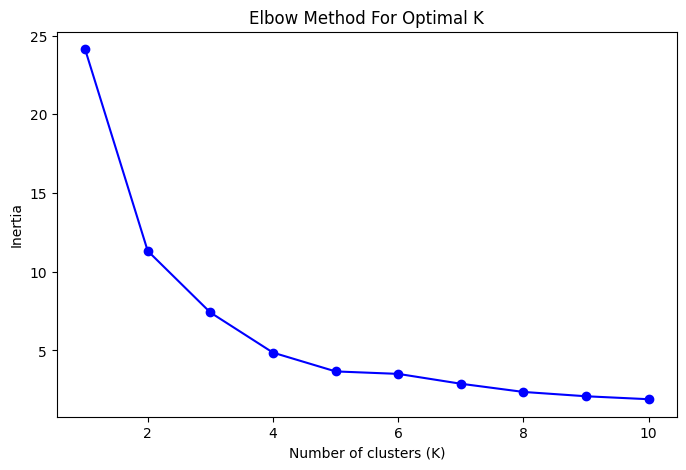

        Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
0           1          2 2015-06-30   5735        568     1      1   
1           2          2 2015-06-30   9863        877     1      1   
2           3          2 2015-06-30  13261       1072     1      1   
3           4          2 2015-06-30  13106       1488     1      1   
4           5          2 2015-06-30   6635        645     1      1   
...       ...        ...        ...    ...        ...   ...    ...   
982639   1111          2 2013-01-01      0          0     0      0   
982640   1112          2 2013-01-01      0          0     0      0   
982641   1113          2 2013-01-01      0          0     0      0   
982642   1114          2 2013-01-01      0          0     0      0   
982643   1115          2 2013-01-01      0          0     0      0   

        SchoolHoliday  Year  Month  Day  StateHoliday_0  StateHoliday_a  \
0                   0  2015      6   30             1.0             0.0   
1        

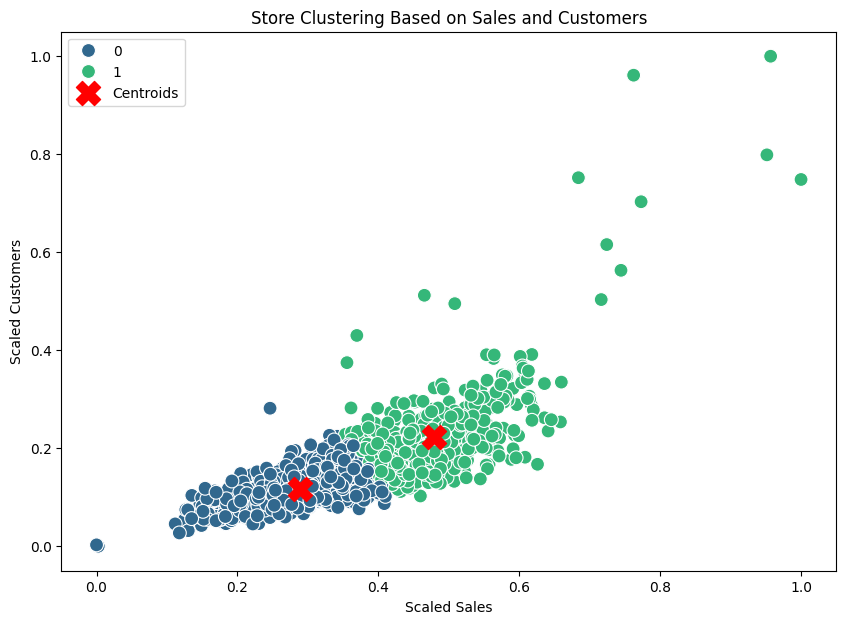

Epoch 1/5


/home/rynem8/anaconda3/envs/py312/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0120 - mean_absolute_error: 0.0708 - root_mean_squared_error: 0.1095 - val_loss: 0.0101 - val_mean_absolute_error: 0.0605 - val_root_mean_squared_error: 0.1006
Epoch 2/5
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0109 - mean_absolute_error: 0.0668 - root_mean_squared_error: 0.1046 - val_loss: 0.0096 - val_mean_absolute_error: 0.0595 - val_root_mean_squared_error: 0.0982
Epoch 3/5
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0104 - mean_absolute_error: 0.0651 - root_mean_squared_error: 0.1017 - val_loss: 0.0093 - val_mean_absolute_error: 0.0587 - val_root_mean_squared_error: 0.0962
Epoch 4/5
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0100 - mean_absolute_error: 0.0639 - root_mean_squared_error: 0.0998 - val_loss: 0.0087 - val_mean_absolute_error: 0.0567 - val_root_mean_squared_error: 0.0935
Epoch 5/5
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0095 - mean_absolute_error: 0.0624 - root_mean_squared_error

/home/rynem8/anaconda3/envs/py312/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


295/295 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0335 - mean_absolute_error: 0.1204 - root_mean_squared_error: 0.1831 - val_loss: 0.0290 - val_mean_absolute_error: 0.1084 - val_root_mean_squared_error: 0.1702
Epoch 2/5
295/295 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0302 - mean_absolute_error: 0.1129 - root_mean_squared_error: 0.1736 - val_loss: 0.0271 - val_mean_absolute_error: 0.1021 - val_root_mean_squared_error: 0.1646
Epoch 3/5
295/295 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0286 - mean_absolute_error: 0.1089 - root_mean_squared_error: 0.1690 - val_loss: 0.0266 - val_mean_absolute_error: 0.1007 - val_root_mean_squared_error: 0.1632
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0290 - mean_absolute_error: 0.1081 - root_mean_squared_error: 0.1702
LSTM model error Score--->  [0.028965342789888382, 0.10841706395149231, 0.17019207775592804]
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
MAE

In [16]:
from sklearn.cluster import KMeans
# Prepare the data for clustering using 'Sales' and 'Customers' features
print('Original dataset:\n',rawIdata)
cluster_data = rawIdata.groupby('Store')[['Sales', 'Customers']].mean()
print('New dataset grouped by store:\n',cluster_data)

# Normalize the data for clustering
scaler = MinMaxScaler()
scaled_cluster_data = scaler.fit_transform(cluster_data)

# Determine the optimal number of clusters using the Elbow Method
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_cluster_data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal K')
plt.show()

# We choose number of clusters as 2 from the elbow method
C = 2
# Cluster stores into 2 clusters
kmeans = KMeans(n_clusters=C, random_state=42)
store_clusters = kmeans.fit_predict(scaled_cluster_data)

# Create a new DataFrame for store clusters
store_cluster_df = pd.DataFrame({
    'Store': cluster_data.index,
    'Cluster': store_clusters
})

# Merge cluster labels back into the original dataset
Idata = pd.merge(rawIdata, store_cluster_df, on='Store')
print(rawIdata)


# Scatter plot of clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x=scaled_cluster_data[:, 0], y=scaled_cluster_data[:, 1], hue=store_clusters, palette='viridis', s=100)
plt.title('Store Clustering Based on Sales and Customers')
plt.xlabel('Scaled Sales')
plt.ylabel('Scaled Customers')

# Plotting cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=300, c='red', label='Centroids', marker='X')

plt.legend()
plt.show()

Idata = Idata[['Store','Date','Sales','Customers','Open','Promo', 'SchoolHoliday', 'StateHoliday_0', 'Cluster']]

# Prepare to store model performances
cluster_R2 = {}

# Iterate over each cluster
for cluster in Idata['Cluster'].unique():
    # Filter data for the current cluster
    cluster_df = Idata[Idata['Cluster'] == cluster]
    
    # Sort the data by date
    cluster_df = cluster_df.sort_values(by=['Store', 'Date'])
    
    # Normalize the sales data
    scaler = MinMaxScaler()
    cluster_df['Sales_scaled'] = scaler.fit_transform(cluster_df['Sales'].values.reshape(-1, 1))
    
    # Create LSTM input-output data
    X_lstm, y_lstm = create_recurrent_data(cluster_df['Sales_scaled'].values, 30)
    X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))
    
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)
    
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    
    # Compile the model
    lstm_model.compile(optimizer='Adam', loss='mean_squared_error', metrics=['mean_absolute_error',tf.keras.metrics.RootMeanSquaredError()])

    # Train the model
    history_lstm = lstm_model.fit(X_train, y_train, epochs=5, batch_size=1028, validation_data=(X_test, y_test), callbacks= es)

    # Printing model score on test data
    print("LSTM model error Score---> ", lstm_model.evaluate(X_test, y_test, verbose=1))

    # Assuming y_true contains the actual sales and y_pred contains the predicted sales from the model
    # Get predictions and evaluate the performance
    y_pred = lstm_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    # Convert MAE and RMSE to percentages
    mae_percent = (mae / np.mean(y_test)) * 100
    rmse_percent = (rmse / np.mean(y_test)) * 100

    print(f"MAE : {mae_percent:.2f}%")
    print(f"RMSE : {rmse_percent:.2f}%")

    metric = tf.keras.metrics.R2Score()
    metric.update_state(y_test, y_pred)
    result = metric.result()

    print(f"\nThe R2 score of the LTSM model on the testing data is: {result*100:.2f} % Accuracy")

    cluster_R2[f'Cluster {cluster}'] = result

# Compare RMSE for each cluster
print(cluster_R2)


Applying ANN:
We get the relevant data and split ito training and testing sets. Next we use Keras hypertuner to build a ANN model using random search that find optimal hyperparamets that will give us low loss. 
After evaluation of the model, we conclude that the traditional ML models specifically the RF non linear model perform better than the ANN models. While the ANN models work similarly to linear model.

In [14]:
#Splitting Data for Training and Testing
# Define target variable and features
Idata = rawIdata[col] # Droping irrelevant features, keeping only relevant ones that have correlation above 0 with sales
X = Idata.drop(columns=['Sales'])  # Exclude 'Sales'
y = Idata['Sales']
print(X)


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['Store'])


# Defining a custome ANN model for hyperparameter tuning. The model will have 1 input layer, 1-3 hidden layer and 1 output layer
# The model will be compiled with different hyperparameters like activation function, optimizer, learning rate, dropout and number of hidden layers
def build_model(hp):
    active_func = hp.Choice('activation', ['relu', 'tanh'])
    optimizer = hp.Choice('optimizer', ['adam', 'SGD', 'RMSprop'])
    lr = hp.Float('learning_rate', min_value=0.001, max_value=0.1, sampling='log', step=10)
    drop = hp.Float('dropout', min_value=0.1, max_value=0.5, sampling= 'linear',step=0.1)
    inputs = tf.keras.Input(shape=[X_train.shape[1],])

    # create hidden layers
    dnn_units = hp.Int(f"0_units", min_value=32, max_value=512)
    dense = tf.keras.layers.Dense(units=dnn_units, activation=active_func)(inputs)
    for layer_i in range(hp.Choice("n_layers", [2,3,4]) - 1):
        dnn_units = hp.Int(f"{layer_i}_units", min_value=32, max_value=512)
        dense = tf.keras.layers.Dense(units=dnn_units, activation=active_func)(dense)
        dense = tf.keras.layers.Dropout(rate=drop)(dense)
    outputs = tf.keras.layers.Dense(units=1, activation='relu')(dense)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    # compile the model choosing the optimizer and learning rate
    if optimizer == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer == "SGD":
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    elif optimizer == "RMSprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
    else:
        raise("Not supported optimizer")
        
    model.compile(optimizer=optimizer,loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])
    return model

# Tuner for random search
tuner = kt.RandomSearch(build_model, objective=kt.Objective('val_loss', direction='min'), max_trials=5, executions_per_trial=2, project_name="RandomSearch", directory="v2")

# Define the early stopping callback
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=30, restore_best_weights=True, verbose=1, mode='min')

# Search for the best hyperparameters
tuner.search(X_train, y_train, batch_size=1024, epochs=10, verbose=1, validation_data=(X_test, y_test))
print(tuner.results_summary())
print('The best hyperparameters are:\n',tuner.get_best_hyperparameters()[0].values)
best_model = build_model(tuner.get_best_hyperparameters(1)[0])
best_model.summary()

# Training full dataset the ANN model architecture with the best hyperparameters
best_model.fit(X_train, y_train, epochs=50, batch_size = 1024, validation_data=(X_test, y_test), callbacks=es)

# Get predictions and evaluate the performance
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Convert MAE and RMSE to percentages
mae_percent = (mae / np.mean(y_test)) * 100
rmse_percent = (rmse / np.mean(y_test)) * 100

print(f"ANN MAE : {mae_percent:.2f}%")
print(f"ANN RMSE : {rmse_percent:.2f}%")

metric = tf.keras.metrics.R2Score()
metric.update_state(y_test, y_pred)
result = metric.result()

print(f"\nThe R2 score of the ANN model on the testing data is: {result*100:.2f} % Accuracy")


Trial 5 Complete [00h 01m 09s]
val_loss: 21820763.0

Best val_loss So Far: 1543515.125
Total elapsed time: 00h 06m 04s
Results summary
Results in v2/RandomSearch
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0 summary
Hyperparameters:
activation: relu
optimizer: RMSprop
learning_rate: 0.01
dropout: 0.4
0_units: 185
n_layers: 2
Score: 1543515.125

Trial 2 summary
Hyperparameters:
activation: relu
optimizer: RMSprop
learning_rate: 0.01
dropout: 0.4
0_units: 333
n_layers: 2
Score: 1588475.375

Trial 3 summary
Hyperparameters:
activation: relu
optimizer: adam
learning_rate: 0.001
dropout: 0.2
0_units: 296
n_layers: 4
1_units: 32
2_units: 32
Score: 2359955.1875

Trial 1 summary
Hyperparameters:
activation: tanh
optimizer: adam
learning_rate: 0.1
dropout: 0.5
0_units: 152
n_layers: 2
Score: 11410984.5

Trial 4 summary
Hyperparameters:
activation: tanh
optimizer: adam
learning_rate: 0.001
dropout: 0.4
0_units: 95
n_layers: 4
1_units: 477
2_units: 312
Score: 2182076

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 185)            │         1,665 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 185)            │        34,410 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 185)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           186 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,261 (141.64 KB)

 Trainable params: 36,261 (141.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
748/748 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 4028810.5000 - mean_absolute_error: 1400.4594 - root_mean_squared_error: 1967.1459 - val_loss: 2005239.6250 - val_mean_absolute_error: 961.0723 - val_root_mean_squared_error: 1416.0648
Epoch 2/50
748/748 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2500793.2500 - mean_absolute_error: 1105.6427 - root_mean_squared_error: 1581.3447 - val_loss: 1785450.7500 - val_mean_absolute_error: 965.7562 - val_root_mean_squared_error: 1336.2076
Epoch 3/50
748/748 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2317507.0000 - mean_absolute_error: 1063.8778 - root_mean_squared_error: 1522.3256 - val_loss: 1891625.6250 - val_mean_absolute_error: 938.3724 - val_root_mean_squared_error: 1375.3638
Epoch 4/50
748/748 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2229310.2500 - mean_absolute_error: 1042.2844 - root_mean_squared_error: 1493.0784 - val_loss: 1595221.3750 - val_mean_absolute_error: 893.4655 - val_root_mean_squared_error: 1263.0208
Epoch 5/50
748/748 ━